In [1]:
import tensorflow as tf
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import data

- The idea was to find two seeds:
one that can produce such random gaussian 2D dataset which Logistic Regression <b>cannot separate linearly</b> into classes, and another seed that <b>can produce linearly separable</b> dataset

In [2]:
SEED = 100
NUM_EXAMPLES = 50
CLASSES = 3
DISTRIBUTIONS = 6

In [3]:
class TFLogreg:
    
    """
        Class that represents a tensorflow implementation of Logistic Regression model.
    """

    def __init__(self, D, C, param_delta=0.1, param_lambda=0.01, use_regularization=True):
        """Arguments:
           - D: dimensions of each datapoint
           - C: number of classes
           - param_delta: training step
           - param_lambda= regularization strength
        """
        tf.reset_default_graph()
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, D])
        self.Yoh_ = tf.placeholder(dtype=tf.float32, shape=[None, C])
        self.W = tf.Variable(initial_value=tf.random_normal([D, C]))
        self.b = tf.Variable(initial_value=tf.random_normal([1, C]))

        self.probs = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b)

        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs), reduction_indices=[1]))
        if use_regularization:
            self.regularization = param_lambda * tf.nn.l2_loss(self.W)
            self.loss = self.cross_entropy + self.regularization
        else:
            self.loss = self.cross_entropy

        self.train_step = tf.train.GradientDescentOptimizer(param_delta).minimize(self.loss)
        
        self.session = tf.Session()

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        self.session.run(tf.global_variables_initializer())

        for i in range(param_niter+1):
            tr, loss = self.session.run([self.train_step, self.loss], feed_dict={self.X: X, self.Yoh_: Yoh_})
            if i % 1000 == 0:
                print("{0:4}. Loss: {1:.8f}".format(i, loss))

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        probs = self.session.run(self.probs, feed_dict={self.X: X})
        return probs

    def classify(self, X):
        return np.argmax(self.eval(X), axis=1)

    def eval_perf(self, Y, Y_):
        # needed to compute scores of our model
        # 'weighted' takes into consideration labels imbalance
        if max(int(max(Y_) + 1), int(max(Y) + 1)) == 2:
            average = 'binary'
        else:
            average = 'weighted'

        accuracy = accuracy_score(Y_, Y)
        precision = precision_score(Y_, Y, average=average)
        recall = recall_score(Y_, Y, average=average)
        f1 = f1_score(Y_, Y, average=average)

        print("Accuracy: {0:.3f}\n"
              "Precision: {1:.3f}\n"
              "Recall: {2:.3f}\n"
              "F1: {3:.3f} ".format(accuracy, precision, recall, f1))

In [4]:
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [5]:
X, Y_ = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

- We are working with one hotted vectors of labels
- for example:

    Y :
        [2, 0, 1]
    
    Yoh_ :
        [0, 0, 1]
        [1, 0, 0] 
        [0, 1, 0]

In [6]:
Yoh_ = Y_.reshape(-1)
Yoh_ = np.eye(CLASSES)[Yoh_]

In [7]:
tflr = TFLogreg(X.shape[1], Yoh_.shape[1], param_delta=0.02, param_lambda=0.02)

In [8]:
print("With regularization:")
tflr.train(X, Yoh_, 10000)

probs = tflr.eval(X)

print("\n")
tflr.eval_perf(np.argmax(probs, axis=1), np.argmax(Yoh_, axis=1))

With regularization:
   0. Loss: 11.01617527
1000. Loss: 1.01100314
2000. Loss: 0.97324169
3000. Loss: 0.96419168
4000. Loss: 0.96126932
5000. Loss: 0.96018726
6000. Loss: 0.95975733
7000. Loss: 0.95957911
8000. Loss: 0.95950341
9000. Loss: 0.95947057
10000. Loss: 0.95945621


Accuracy: 0.403
Precision: 0.335
Recall: 0.403
F1: 0.366 


In [9]:
tflr.session.run(tflr.W)

array([[ 0.25858766, -0.14758922, -0.05490297],
       [ 0.04911043, -0.02936112, -0.03355389]], dtype=float32)

In [10]:
tflr_noreg = TFLogreg(X.shape[1], Yoh_.shape[1], param_delta=0.02, param_lambda=0.02, use_regularization=False)

print("Without regularization:")
tflr_noreg.train(X, Yoh_, 10000)

probs_noreg = tflr_noreg.eval(X)

print("\n")
tflr_noreg.eval_perf(np.argmax(probs_noreg, axis=1), np.argmax(Yoh_, axis=1))

Without regularization:
   0. Loss: 5.01071453
1000. Loss: 0.98010492
2000. Loss: 0.96327305
3000. Loss: 0.95973778
4000. Loss: 0.95883805
5000. Loss: 0.95858729
6000. Loss: 0.95851427
7000. Loss: 0.95849258
8000. Loss: 0.95848596
9000. Loss: 0.95848393
10000. Loss: 0.95848322


Accuracy: 0.403
Precision: 0.335
Recall: 0.403
F1: 0.366 


In [11]:
probs_noreg = tflr_noreg.eval(X)
probs_noreg

array([[ 0.13050704,  0.46509361,  0.40439937],
       [ 0.25976562,  0.34443825,  0.39579606],
       [ 0.24754325,  0.36075562,  0.39170113],
       [ 0.19967711,  0.4003619 ,  0.39996099],
       [ 0.28761479,  0.32831639,  0.38406879],
       [ 0.19932565,  0.38831598,  0.41235846],
       [ 0.36029422,  0.28325003,  0.35645577],
       [ 0.16855682,  0.4191463 ,  0.41229686],
       [ 0.12027077,  0.46056199,  0.41916722],
       [ 0.39039806,  0.25785121,  0.35175067],
       [ 0.29790542,  0.31843802,  0.38365653],
       [ 0.2360341 ,  0.36296308,  0.40100288],
       [ 0.11304253,  0.46825179,  0.4187057 ],
       [ 0.37957084,  0.2697241 ,  0.35070509],
       [ 0.49826476,  0.20503294,  0.29670236],
       [ 0.38462725,  0.26358667,  0.35178611],
       [ 0.34437078,  0.28743255,  0.36819673],
       [ 0.24721619,  0.35922134,  0.39356244],
       [ 0.38557786,  0.26907852,  0.34534359],
       [ 0.23988554,  0.35889307,  0.40122145],
       [ 0.35736924,  0.28227326,  0.360

In [12]:
tflr_noreg.session.run(tflr_noreg.W)

array([[ 0.25318304, -0.15701097, -0.06339086],
       [-0.93145376, -1.01080811, -1.01474965]], dtype=float32)

- We can see the insecurity model has due to having a linearly unseparable dataset by looking at probabilities

- the difference on this dataset with or without regularization did not give any important changes, only changing the model for one less accurate data point classification (notice just bellow the peak in the middle)

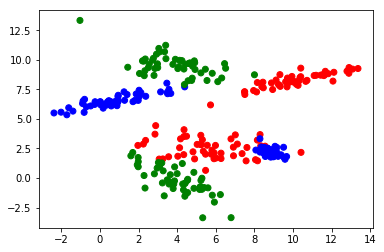

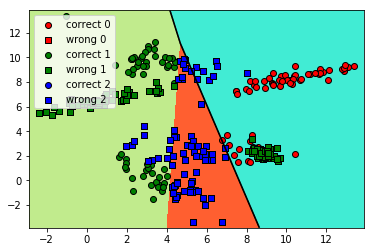

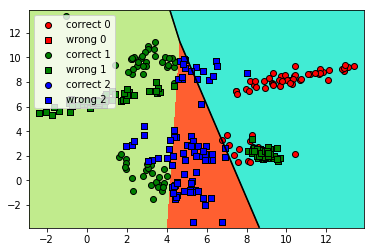

In [13]:
colors = ['red', 'green', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=Y_.flatten(), cmap=ListedColormap(colors))
plt.show()

data.plot_decision_boundary(X, lambda x: tflr.classify(x))
# graph the data points
data.graph_data(X, Y_, np.argmax(probs, axis=1))

data.plot_decision_boundary(X, lambda x: tflr_noreg.classify(x))
# graph the data points
data.graph_data(X, Y_, np.argmax(probs_noreg, axis=1))

In [14]:
SEED = 125
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [15]:
X2, Y_2 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [16]:
Yoh_2 = Y_2.reshape(-1)
Yoh_2 = np.eye(CLASSES)[Yoh_2]

In [17]:
tflr2 = TFLogreg(X2.shape[1], Yoh_2.shape[1], param_delta=0.02, param_lambda=0.02)

In [18]:
print("With regularization:")
tflr2.train(X2, Yoh_2, 50000)

With regularization:
   0. Loss: 5.67684364
1000. Loss: 0.52810776
2000. Loss: 0.45602524
3000. Loss: 0.41509348
4000. Loss: 0.38874686
5000. Loss: 0.37021610
6000. Loss: 0.35633335
7000. Loss: 0.34546000
8000. Loss: 0.33667314
9000. Loss: 0.32941222
10000. Loss: 0.32331252
11000. Loss: 0.31812352
12000. Loss: 0.31366491
13000. Loss: 0.30980211
14000. Loss: 0.30643207
15000. Loss: 0.30347419
16000. Loss: 0.30086404
17000. Loss: 0.29854992
18000. Loss: 0.29648939
19000. Loss: 0.29464760
20000. Loss: 0.29299551
21000. Loss: 0.29150870
22000. Loss: 0.29016683
23000. Loss: 0.28895223
24000. Loss: 0.28785020
25000. Loss: 0.28684807
26000. Loss: 0.28593445
27000. Loss: 0.28510007
28000. Loss: 0.28433636
29000. Loss: 0.28363639
30000. Loss: 0.28299367
31000. Loss: 0.28240249
32000. Loss: 0.28185806
33000. Loss: 0.28135580
34000. Loss: 0.28089187
35000. Loss: 0.28046298
36000. Loss: 0.28006598
37000. Loss: 0.27969801
38000. Loss: 0.27935651
39000. Loss: 0.27903950
40000. Loss: 0.27874464
41000

In [19]:
probs2 = tflr2.eval(X2)
tflr2.eval_perf(np.argmax(probs2, axis=1), np.argmax(Yoh_2, axis=1))

Accuracy: 0.903
Precision: 0.901
Recall: 0.903
F1: 0.902 


In [20]:
tflr2.session.run(tflr2.W)

array([[ 0.2610521 , -0.6714707 ,  0.41041818],
       [ 1.33378029, -0.87719661, -0.45661172]], dtype=float32)

In [21]:
tflr2_noreg = TFLogreg(X2.shape[1], Yoh_2.shape[1], param_delta=0.02, param_lambda=0.02, use_regularization=False)
print("Without regularization:")
tflr2_noreg.train(X2, Yoh_2, 50000)

probs2_noreg = tflr2_noreg.eval(X2)

Without regularization:
   0. Loss: 4.81972694
1000. Loss: 0.48423335
2000. Loss: 0.42970783
3000. Loss: 0.39558363
4000. Loss: 0.37157527
5000. Loss: 0.35335919
6000. Loss: 0.33887917
7000. Loss: 0.32701162
8000. Loss: 0.31707239
9000. Loss: 0.30861098
10000. Loss: 0.30131385
11000. Loss: 0.29495323
12000. Loss: 0.28935882
13000. Loss: 0.28439999
14000. Loss: 0.27997440
15000. Loss: 0.27600083
16000. Loss: 0.27241379
17000. Loss: 0.26915985
18000. Loss: 0.26619506
19000. Loss: 0.26348266
20000. Loss: 0.26099202
21000. Loss: 0.25869715
22000. Loss: 0.25657591
23000. Loss: 0.25460947
24000. Loss: 0.25278163
25000. Loss: 0.25107810
26000. Loss: 0.24948689
27000. Loss: 0.24799721
28000. Loss: 0.24659945
29000. Loss: 0.24528557
30000. Loss: 0.24404824
31000. Loss: 0.24288076
32000. Loss: 0.24177767
33000. Loss: 0.24073343
34000. Loss: 0.23974366
35000. Loss: 0.23880428
36000. Loss: 0.23791142
37000. Loss: 0.23706149
38000. Loss: 0.23625168
39000. Loss: 0.23547909
40000. Loss: 0.23474137
41

In [22]:
tflr2_noreg.eval_perf(np.argmax(probs2_noreg, axis=1), np.argmax(Yoh_2, axis=1))

Accuracy: 0.903
Precision: 0.902
Recall: 0.903
F1: 0.902 


In [23]:
tflr2_noreg.session.run(tflr2_noreg.W)

array([[ 0.80691695, -0.21109726,  1.00816894],
       [ 2.20005155, -0.44615942,  0.08190547]], dtype=float32)

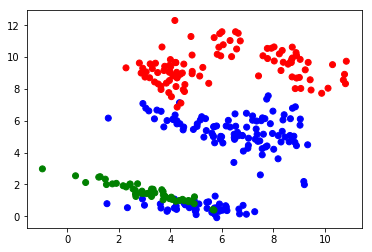

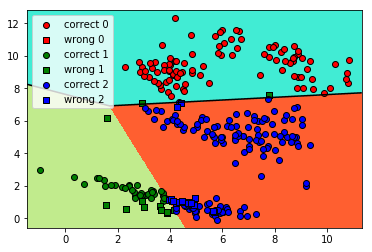

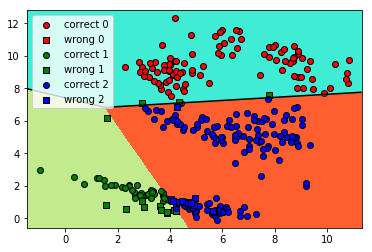

In [24]:
plt.scatter(X2[:, 0], X2[:, 1], c=Y_2.flatten(), cmap=ListedColormap(colors))
plt.show()

data.plot_decision_boundary(X2, lambda x: tflr2.classify(x))
# graph the data points
data.graph_data(X2, Y_2, np.argmax(probs2, axis=1))

data.plot_decision_boundary(X2, lambda x: tflr2_noreg.classify(x))
# graph the data points
data.graph_data(X2, Y_2, np.argmax(probs2_noreg, axis=1))